# TP 3 : Reinforcement Learning with Function Approximation

# 0 - Packages

In [1]:
# Mathematical packages
import numpy as np

# Matplotlib packages
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set()

# Import tqdm as tqdm 
import tqdm as tqdm

# Local packages
import lqg1d
import utils

# 1 - On-Policy Reinforcement Learning with Parametric Policy


## 1.1 - Guassian policy model

In [2]:
class gaussianPolicy(object):
    """Define a gaussian policy with parameter theta and sigma."""
    
    def __init__(self, theta, sigma=0.4, sigma_constant=True):
        """Initialisation of the policy."""
        self.theta = theta
        self.sigma = sigma
        self.sigma_constant=sigma_constant
        
    def mu_theta(self, s):
        """Definition of the mu fonction according to theta."""
        return self.theta * s
    
    def d_mu_theta(self, s):
        """Definition of the differentiate of mu_theta."""
        return s
    
    def sigma_w(self, s):
        """Definiton of the sigma for our model."""
        if self.sigma_constant:
            return self.sigma
        else:
            return np.sqrt((self.sigma * s) ** 2)
    
    def d_sigma_w(self, s):
        """Definition of the differentiate of sigma_w for our model."""
        if self.sigma_constant:
            return 0
        else:
            return self.sigma

    def draw_action(self, s):
        """Return a sampled action according to the gaussian policy at state s."""
    
        # Draw a sample of the gaussian policy
        result = np.random.normal(self.mu_theta(s), self.sigma_w(s))

        return result
    
    def gradientGaussianPolicy(self, a, s):
        """Return the log-gradient of the gaussian policy taken in a and s."""

        # Initialisation of the gradient 
        log_g = np.zeros((2,1))

        # Computation of the gradient in theta
        log_g[0] = (a - self.mu_theta(s)) / (self.sigma_w(s) ** 2) * self.d_mu_theta(s)

        # Computation of the gradient in w
        log_g[1] = ((a - self.mu_theta(s)) ** 2 - self.sigma_w(s) ** 2) * self.d_sigma_w(s)
        log_g[1] /= (self.sigma_w(s) ** 3) 

        return log_g

## 1.2 - Adam - Step Optimization

In [3]:
class AdamStep(object):
    def __init__(self, d=2, alpha=0.001, beta_1=0.9, beta_2=0.999, epsilon=10e-8):
        self.alpha = alpha
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        self.m_t = 0
        self.v_t = 0
        self.t = 0
        
    def update(self, g_t):
        """Execute one step of the Adam algorithm.
           cf https://arxiv.org/pdf/1412.6980.pdf"""
        
        self.t = self.t + 1
        self.m_t = self.beta_1 * self.m_t + (1 - self.beta_1) * g_t
        self.v_t = self.beta_2 * self.v_t + (1 - self.beta_2) * g_t * g_t
        hat_m_t = self.m_t / (1 - self.beta_1 ** self.t)
        hat_v_t = self.v_t / (1 - self.beta_2 ** self.t)
        step = self.alpha * hat_m_t / (np.sqrt(hat_v_t) + self.epsilon)
        
        return step

## 1.3 - Constant Step

In [4]:
class ConstantStep(object):
    """Define a step optimisation class with a constant learning rate."""
    
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate

    def update(self, gt):
        return self.learning_rate * gt 

## 1.4 - REINFORCE Algorithm

In [5]:
def computeCIBounds(array):
    """Compute the empirical 95% CI bounds."""
    
    # Shape
    n, n_iter = np.shape(array)
    
    # Compute the empirical variances
    emp_variance = np.std(array, axis=0)
    
    # Compute the emprical mean
    emp_mean = np.mean(array, axis=0)
    
    # Compute the bounds
    low_CI = emp_mean - 1.96 * emp_variance / np.sqrt(n)
    high_CI = emp_mean + 1.96 * emp_variance / np.sqrt(n)
    
    return low_CI, high_CI

In [6]:
def REINFORCE(env, Policy, n_experiences=5, n_itr=100, N=100, T=100,
              Step=ConstantStep(10e-5), sigma_w=0.4, addOptimism=None):
    """Executes the REINFORCE algorithm on env."""
    
    # Saving array for the avg of mean_parameters and avg_return
    mean_parameters = np.zeros((n_experiences, n_itr))
    avg_return = np.zeros((n_experiences, n_itr))

    for j in tqdm.tqdm(range(n_experiences)):

        # Intialisation of theta_k
        theta_k = np.zeros((2,1)) - 0.1

        # Saving array for the parameters theta and for the return
        parameters = []
        r = []
        
        # Executes n_itr for optimising theta
        for i in range(n_itr):
            
            # Update of the current policy
            policy = Policy(theta_k[0, 0], sigma=sigma_w)

            # Executes all the trajectories
            paths = utils.collect_episodes(env, policy=policy, horizon=T, n_episodes=N)

            # Computation of the gradient step
            g_t = np.zeros((2, 1))

            # Initialisation of the avg_return
            r.append(0)

            for episode in paths:

                # Extract the actions taken
                actions = episode["actions"]
                states = episode["states"]
                rewards = episode["rewards"]
            
                # Update the rewards
                if addOptimism != None:
                    rewards = addOptimism(env, actions, states, rewards)
                    
                # Array of the discounts
                discounts_l = np.array([discount ** t for t in range(len(rewards))])

                for t in range(len(states)):

                    # Extract current state
                    a_t = actions[t, 0]
                    s_t = states[t, 0]

                    # Sum all the future rewards
                    R_t = np.sum(rewards[t:] * discounts_l[t:] * discount ** (-t))

                    # Computation of the gradient of the log 
                    g_log_pi_t = policy.gradientGaussianPolicy(a_t, s_t)

                    # Add it to g_t
                    g_t += g_log_pi_t * R_t

                    # Update the avg_return 
                    if t == 0:
                        r[i] += R_t / N

            # Average of the gradient over the episodes
            g_t = g_t / N

            # Make an iteration of the gradient descent
            theta_k = theta_k + Step.update(g_t)

            # update of the mean parameter
            parameters.append(theta_k[0,0])

        # Update of mean parameters
        parameters = np.array(parameters)

        # Update of mean_parameters_l and avg_return_l
        mean_parameters[j,:] = parameters
        avg_return[j,:] = r
        
    # Compute the CI bounds
    mean_parameters_CI_low, mean_parameters_CI_high = computeCIBounds(mean_parameters)
    avg_return_CI_low, avg_return_CI_high = computeCIBounds(avg_return)
    
    # Normalisation of mean_parameters_l and avg_return_l
    mean_parameters = mean_parameters.mean(axis=0)
    avg_return = avg_return.mean(axis=0)
    
    return [mean_parameters, avg_return, mean_parameters_CI_low, mean_parameters_CI_high,
            avg_return_CI_low, avg_return_CI_high]

## 1.5 - Graphic function

In [7]:
def lineplotCI(ax, x_data, y_data, sorted_x, low_CI, upper_CI, x_label, y_label, title):
    """Plot the points with the confidence interval"""

    # Plot the data, set the linewidth, color and transparency of the
    # line, provide a label for the legend
    ax.plot(x_data, y_data, lw=1, color='#539caf', alpha=1, label='Mean')
    
    # Shade the confidence interval
    ax.fill_between(sorted_x, low_CI, upper_CI, color='#539caf', alpha=0.4, label='95% CI')
    
    # Label the axes and provide a title
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    # Display legend
    ax.legend(loc = 'best')

In [10]:
def figures(mean_parameters, avg_return, mean_parameters_CI_low, mean_parameters_CI_high,
            avg_return_CI_low, avg_return_CI_high):
    """Display the two figures required."""
    
    fig, axs = plt.subplots(1, 2, figsize=(20, 8))
    plt.grid(True)
    
    # plot the average return obtained by simulating the policy
    # at each iteration of the algorithm (this is a rought estimate
    # of the performance
    lineplotCI(axs[0],
               x_data=np.linspace(1, n_itr, n_itr),
               y_data = avg_return,
               sorted_x = np.linspace(1, n_itr, n_itr),
               low_CI = avg_return_CI_low,
               upper_CI = avg_return_CI_high,
               x_label = 'Number of iteration of the gradient ascent',
               y_label = 'Average reward',
               title = 'Average reward over the gradient ascent')

    # plot the distance mean parameter
    # of iteration k
    # Call the function to create plot
    lineplotCI(axs[1],
               x_data = np.linspace(1, n_itr, n_itr),
               y_data = mean_parameters,
               sorted_x = np.linspace(1, n_itr, n_itr),
               low_CI = mean_parameters_CI_low,
               upper_CI = mean_parameters_CI_high,
               x_label = 'Number of iteration of the gradient ascent',
               y_label = 'Theta',
               title = 'Value of theta over the gradient ascent')
    
    plt.show()

## 1.6 - Results

In [11]:
#####################################################
# Define the environment and the policy
#####################################################
env = lqg1d.LQG1D(initial_state_type='random')

#####################################################
# Experiments parameters
#####################################################
# We will collect N trajectories per iteration
N = 100
# Each trajectory will have at most T time steps
T = 100
# Number of policy parameters updates
n_itr = 100
# Set the discount factor for the problem
discount = 0.9
# Learning rate for the gradient update
learning_rate = 10e-5
# define the update rule (stepper)
Step = ConstantStep(learning_rate) #AdamStep() # e.g., constant, adam or anything you want

100%|██████████| 5/5 [04:38<00:00, 55.79s/it]


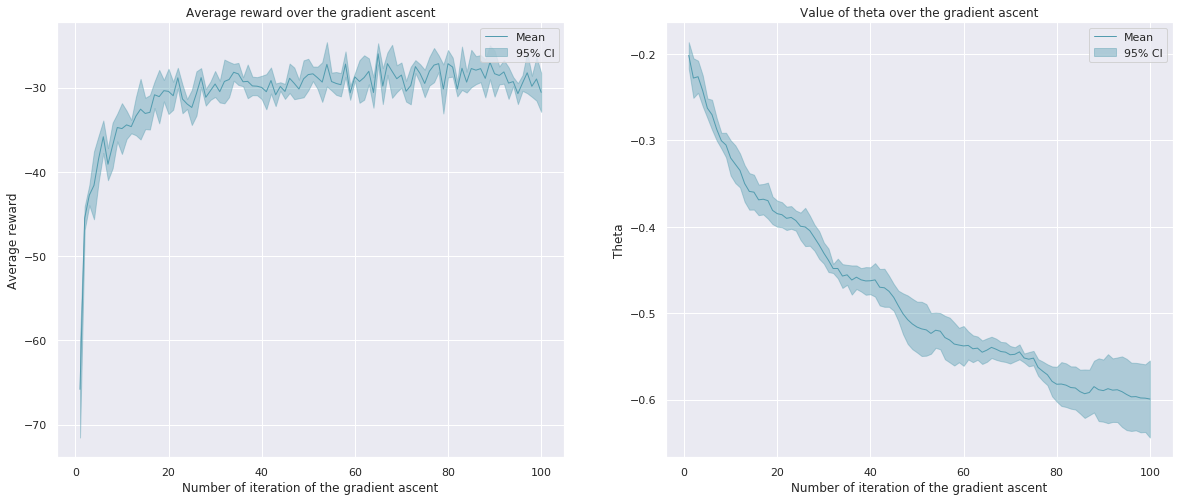

In [9]:
#####################################################
# REINFORCE
#####################################################
# fill the following part of the code with
#  - REINFORCE estimate i.e. gradient estimate
#  - update of policy parameters using the steppers
#  - average performance per iteration
#  - distance between optimal mean parameter and the one at it k

# Number of experiences
n_experiences = 5

# REINFOIRCE algoritm
[mean_parameters, avg_return,
 mean_parameters_CI_low, mean_parameters_CI_high,
 avg_return_CI_low, avg_return_CI_high] = REINFORCE(env, gaussianPolicy,
                                                    n_experiences=n_experiences, n_itr=n_itr,
                                                    N=N, T=T, Step=Step)

#####################################################
# Figures
#####################################################
figures(mean_parameters, avg_return, mean_parameters_CI_low, mean_parameters_CI_high,
        avg_return_CI_low, avg_return_CI_high)

__Commentaries__:
* As initialisation for $\theta$ we choose $\theta = -0.1$. As it is not so far from the optimal $\theta^*$ it allows to converge easier.
* As the gradient becomes really big at the first step we choose a small learning rate; we chose $\alpha_t = 10^{-5}$. The other parameters are left unchanged.
* For the confidence intervals, we use the empirical mean and empirical variance over the different experiences run with 100 optimisation iterations. Here, we use only 5 experiences which is really low but it was already computationnaly costly

## 1.7 - Influence of the parameters

### 1.7.1 Influence of N

100%|██████████| 5/5 [09:10<00:00, 109.76s/it]


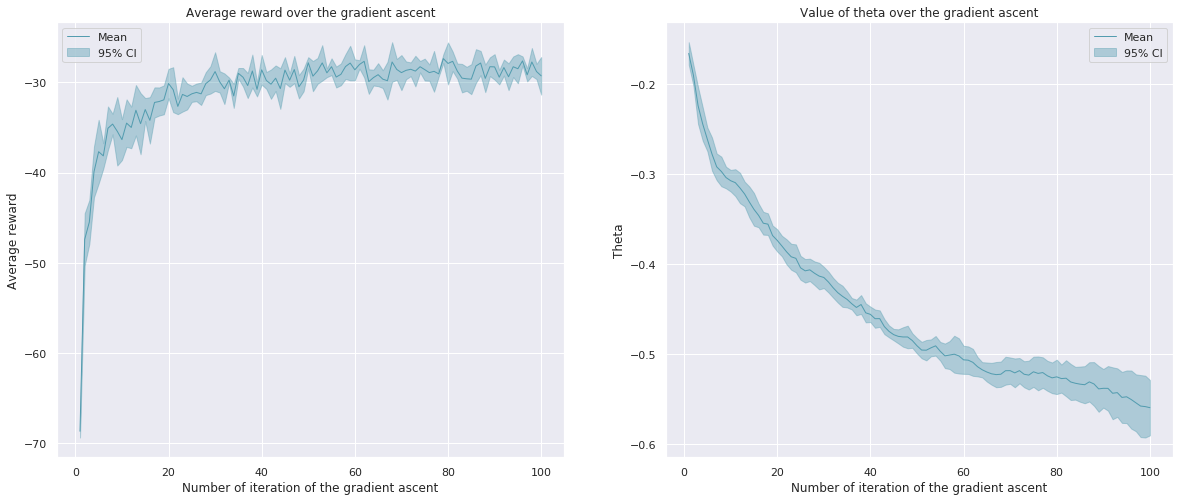

In [10]:
### High N
N = 200

# REINFOIRCE algoritm
[mean_parameters, avg_return,
 mean_parameters_CI_low, mean_parameters_CI_high,
 avg_return_CI_low, avg_return_CI_high] = REINFORCE(env, gaussianPolicy, N=N)

#####################################################
# Figures
#####################################################
figures(mean_parameters, avg_return, mean_parameters_CI_low, mean_parameters_CI_high,
        avg_return_CI_low, avg_return_CI_high)

100%|██████████| 5/5 [00:14<00:00,  2.82s/it]


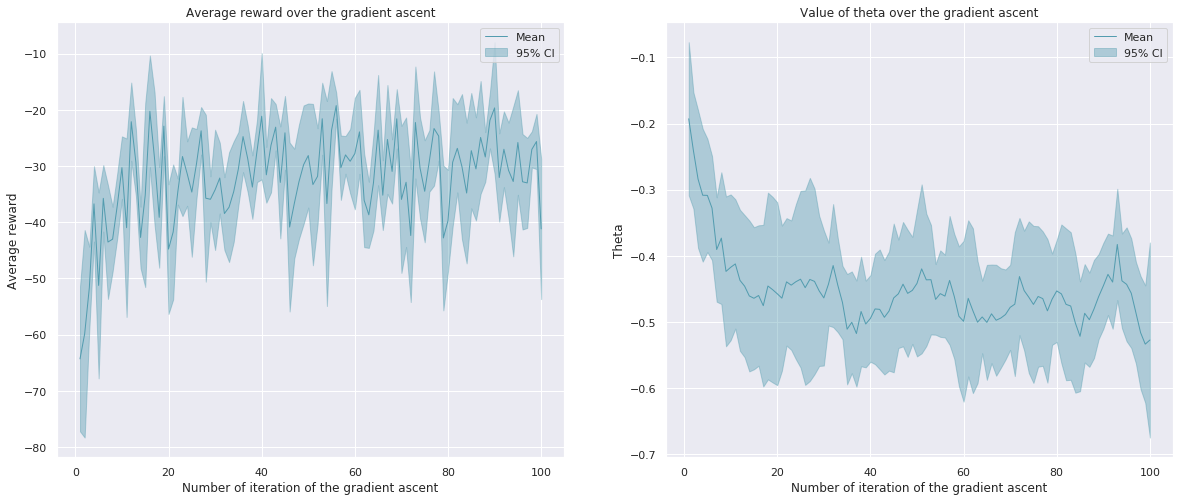

In [11]:
### Low N
N = 5

# REINFOIRCE algoritm
[mean_parameters, avg_return,
 mean_parameters_CI_low, mean_parameters_CI_high,
 avg_return_CI_low, avg_return_CI_high] = REINFORCE(env, gaussianPolicy, N=N)

#####################################################
# Figures
#####################################################
figures(mean_parameters, avg_return, mean_parameters_CI_low, mean_parameters_CI_high,
        avg_return_CI_low, avg_return_CI_high)

__Commentaries__:
* We can observe that N influences mainly the variance of the convergence of both the average reward and the mean theta. It is logic because more N is important, more trajectories are extracted. Therefore, the approximation of the expectation of the current policy is better when N is big and so better is the approximation of $\triangledown J_{theta}^{\pi_{\theta}}$. Hence, it is easier to converge and there is less variance in the results.

### 1.7.2 - Influence of T



  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [02:47<11:10, 167.70s/it]

 40%|████      | 2/5 [05:34<08:22, 167.36s/it]

 60%|██████    | 3/5 [08:20<05:34, 167.07s/it]

 80%|████████  | 4/5 [11:08<02:47, 167.22s/it]

100%|██████████| 5/5 [13:54<00:00, 167.01s/it]



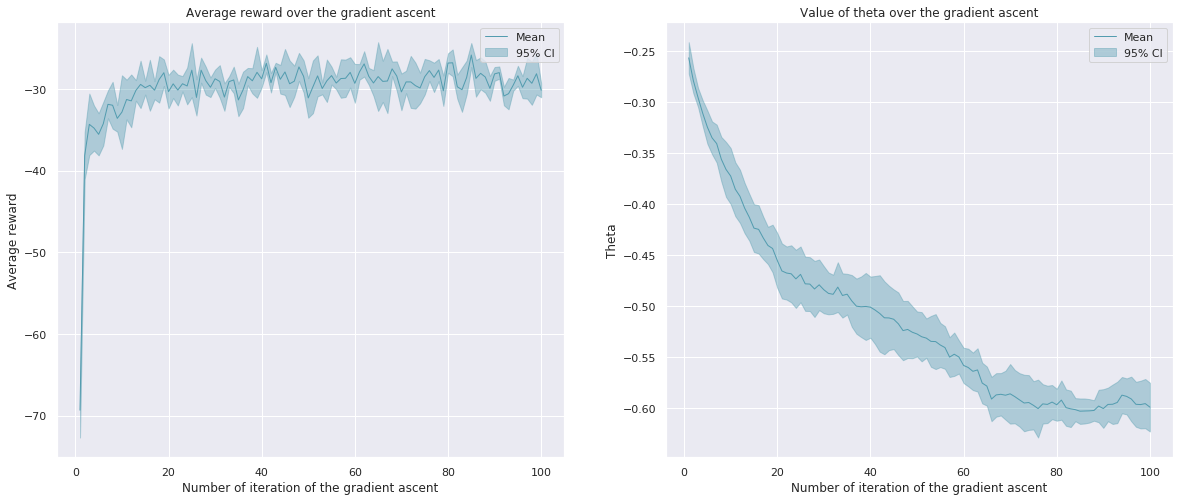

In [51]:
### High T
T = 300

# REINFOIRCE algoritm
[mean_parameters, avg_return,
 mean_parameters_CI_low, mean_parameters_CI_high,
 avg_return_CI_low, avg_return_CI_high] = REINFORCE(env, gaussianPolicy, T=T)

#####################################################
# Figures
#####################################################
figures(mean_parameters, avg_return, mean_parameters_CI_low, mean_parameters_CI_high,
        avg_return_CI_low, avg_return_CI_high)



  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:14<00:56, 14.16s/it]

 40%|████      | 2/5 [00:28<00:42, 14.32s/it]

 60%|██████    | 3/5 [00:42<00:28, 14.23s/it]

 80%|████████  | 4/5 [00:57<00:14, 14.23s/it]

100%|██████████| 5/5 [01:11<00:00, 14.17s/it]



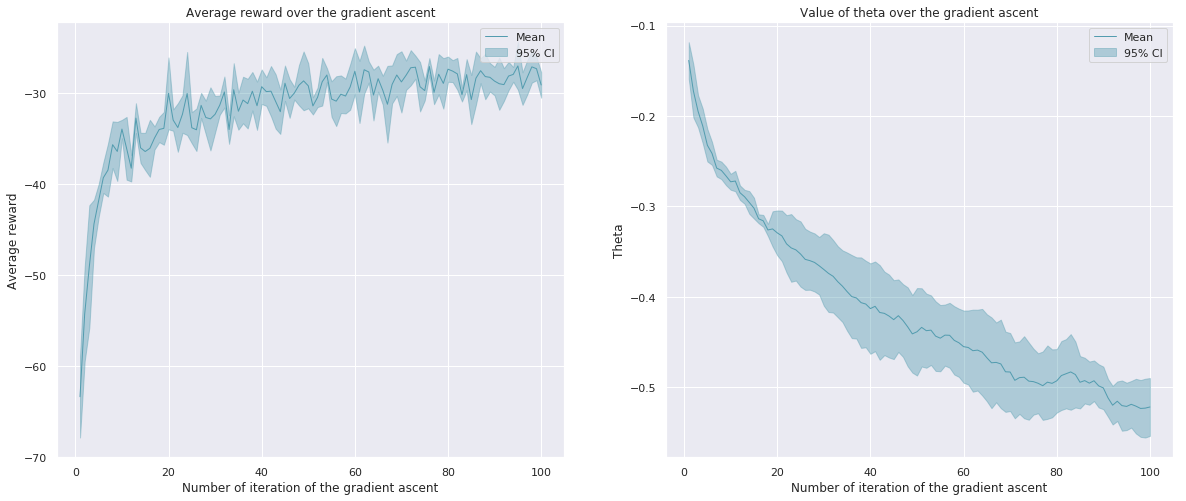

In [52]:
### High T
T = 25

# REINFOIRCE algoritm
[mean_parameters, avg_return,
 mean_parameters_CI_low, mean_parameters_CI_high,
 avg_return_CI_low, avg_return_CI_high] = REINFORCE(env, gaussianPolicy, T=T)

#####################################################
# Figures
#####################################################
figures(mean_parameters, avg_return, mean_parameters_CI_low, mean_parameters_CI_high,
        avg_return_CI_low, avg_return_CI_high)

__Commentaries__:
* With these two graphics on the influence of T, we can remark that when T is bigger, the convergence is quicker. It seems quite logic because when T is bigger, better is our approximation of the expectation of the reward of our current policy. However, when T is bigger, we have also more chance to have bias because we use the sub-trajectories of the trajectories but it seems that it is not the case here. 

### 1.7.3 - Influence of sigma_w



  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:55<03:41, 55.47s/it]

 40%|████      | 2/5 [01:50<02:46, 55.45s/it]

 60%|██████    | 3/5 [02:46<01:50, 55.38s/it]

 80%|████████  | 4/5 [03:40<00:55, 55.19s/it]

100%|██████████| 5/5 [04:36<00:00, 55.39s/it]



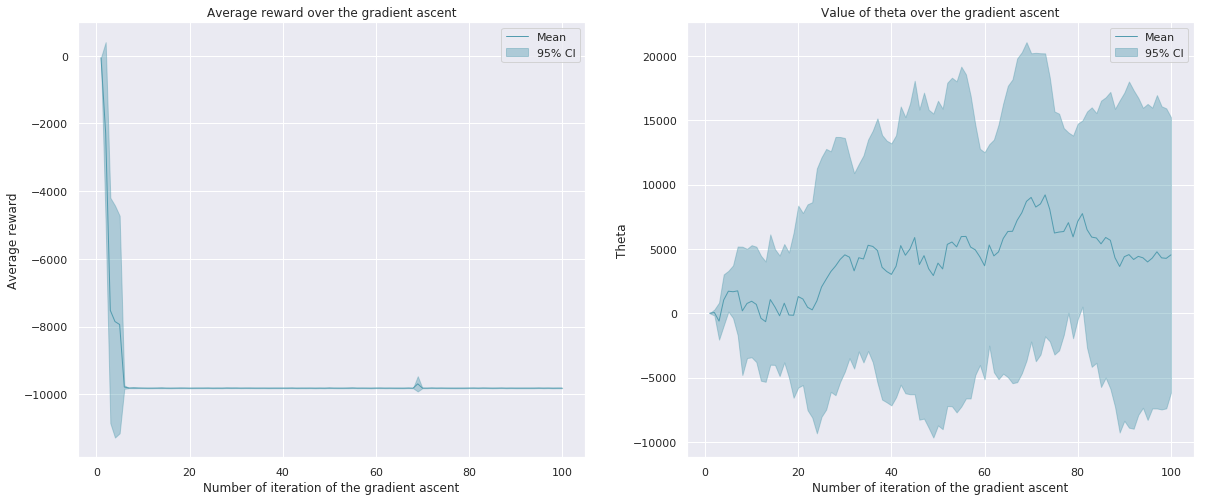

In [53]:
### Low variablity on the actions
sigma_w = 0.01

# REINFOIRCE algoritm
[mean_parameters, avg_return,
 mean_parameters_CI_low, mean_parameters_CI_high,
 avg_return_CI_low, avg_return_CI_high] = REINFORCE(env, gaussianPolicy, sigma_w=sigma_w)

#####################################################
# Figures
#####################################################
figures(mean_parameters, avg_return, mean_parameters_CI_low, mean_parameters_CI_high,
        avg_return_CI_low, avg_return_CI_high)



  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:55<03:40, 55.24s/it]

 40%|████      | 2/5 [01:52<02:47, 55.91s/it]

 60%|██████    | 3/5 [02:49<01:52, 56.16s/it]

 80%|████████  | 4/5 [03:46<00:56, 56.36s/it]

100%|██████████| 5/5 [04:41<00:00, 56.15s/it]



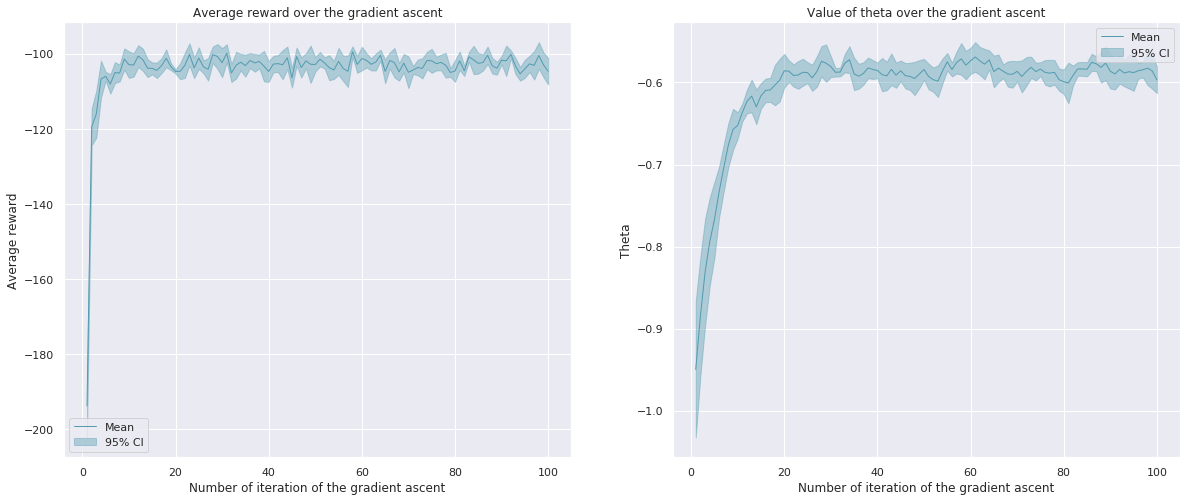

In [77]:
### Low variablity on the actions
sigma_w = 2.5

# REINFOIRCE algoritm
[mean_parameters, avg_return,
 mean_parameters_CI_low, mean_parameters_CI_high,
 avg_return_CI_low, avg_return_CI_high] = REINFORCE(env, gaussianPolicy, sigma_w=sigma_w)

#####################################################
# Figures
#####################################################
figures(mean_parameters, avg_return, mean_parameters_CI_low, mean_parameters_CI_high,
        avg_return_CI_low, avg_return_CI_high)

__Commentaries__:
* With these two graphics we understand better the influence of sigma_w when it is constant. For the both cases, we have considered sigma_w constant but with different value. In the first case, sigma_w is equal to 0.01. In the second case it is equal to 2.5. When sigma_w is low it means that we explore less the space of action and hence of state. So, it seems that by itself our policy does not explore the space of state-action. Therefore it is impossible to converge. When sigma_w is higher, we explore more and we converges much faster.
* Also, even if we converge much faster towards the optimal $\theta^*$, we can observe that the reward is lower because of this high exploration.

### 1.7.5 - Influence of the learning rate



  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:58<03:53, 58.29s/it]

 40%|████      | 2/5 [01:55<02:53, 57.90s/it]

 60%|██████    | 3/5 [02:51<01:54, 57.35s/it]

 80%|████████  | 4/5 [03:47<00:56, 56.97s/it]

100%|██████████| 5/5 [04:43<00:00, 56.85s/it]



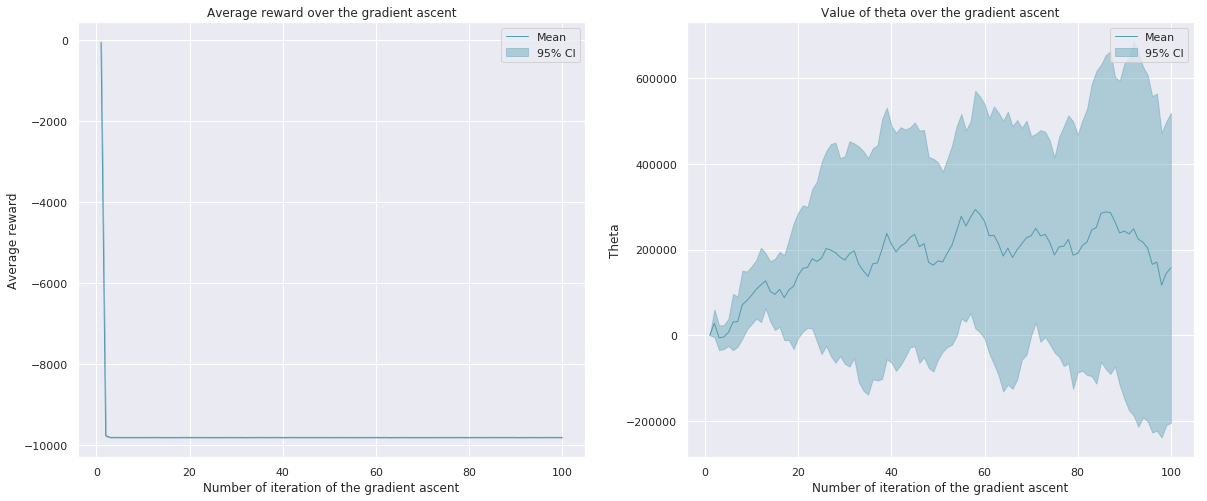

In [65]:
# Learning rate for the gradient update
learning_rate = 0.1

# define the update rule (stepper)
Step = ConstantStep(learning_rate)

# REINFOIRCE algoritm
[mean_parameters, avg_return,
 mean_parameters_CI_low, mean_parameters_CI_high,
 avg_return_CI_low, avg_return_CI_high] = REINFORCE(env, gaussianPolicy, Step=Step)

#####################################################
# Figures
#####################################################
figures(mean_parameters, avg_return, mean_parameters_CI_low, mean_parameters_CI_high,
        avg_return_CI_low, avg_return_CI_high)



  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:55<03:42, 55.51s/it]

 40%|████      | 2/5 [01:51<02:46, 55.54s/it]

 60%|██████    | 3/5 [02:46<01:50, 55.49s/it]

 80%|████████  | 4/5 [03:43<00:55, 55.84s/it]

100%|██████████| 5/5 [04:41<00:00, 56.58s/it]



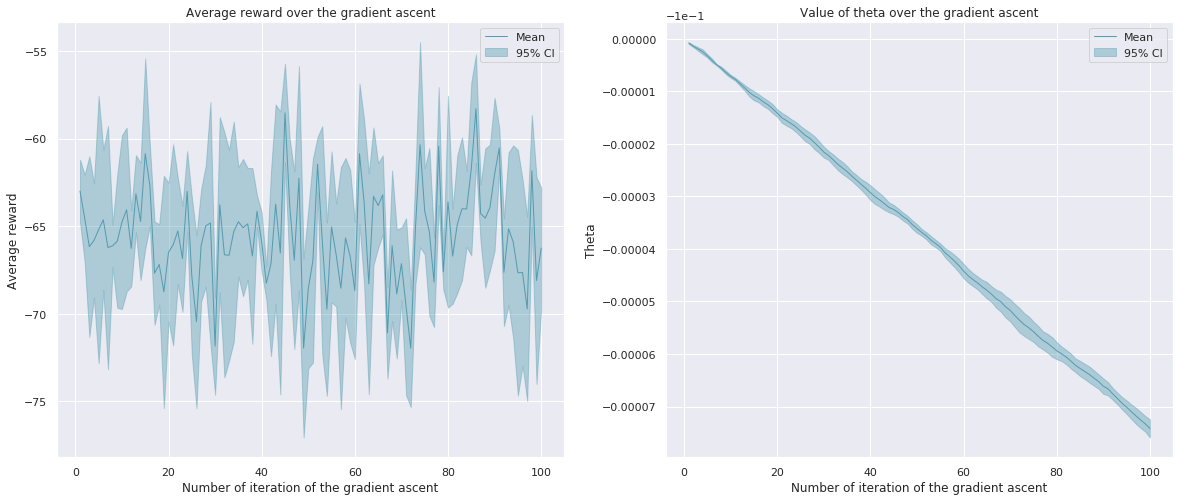

In [58]:
# Learning rate for the gradient update
learning_rate = 10e-10

# define the update rule (stepper)
Step = ConstantStep(learning_rate)

# REINFOIRCE algoritm
[mean_parameters, avg_return,
 mean_parameters_CI_low, mean_parameters_CI_high,
 avg_return_CI_low, avg_return_CI_high] = REINFORCE(env, gaussianPolicy, Step=Step)

#####################################################
# Figures
#####################################################
figures(mean_parameters, avg_return, mean_parameters_CI_low, mean_parameters_CI_high,
        avg_return_CI_low, avg_return_CI_high)



  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:57<03:51, 57.83s/it]

 40%|████      | 2/5 [01:55<02:52, 57.65s/it]

 60%|██████    | 3/5 [02:53<01:55, 57.94s/it]

 80%|████████  | 4/5 [03:50<00:57, 57.61s/it]

100%|██████████| 5/5 [04:47<00:00, 57.48s/it]



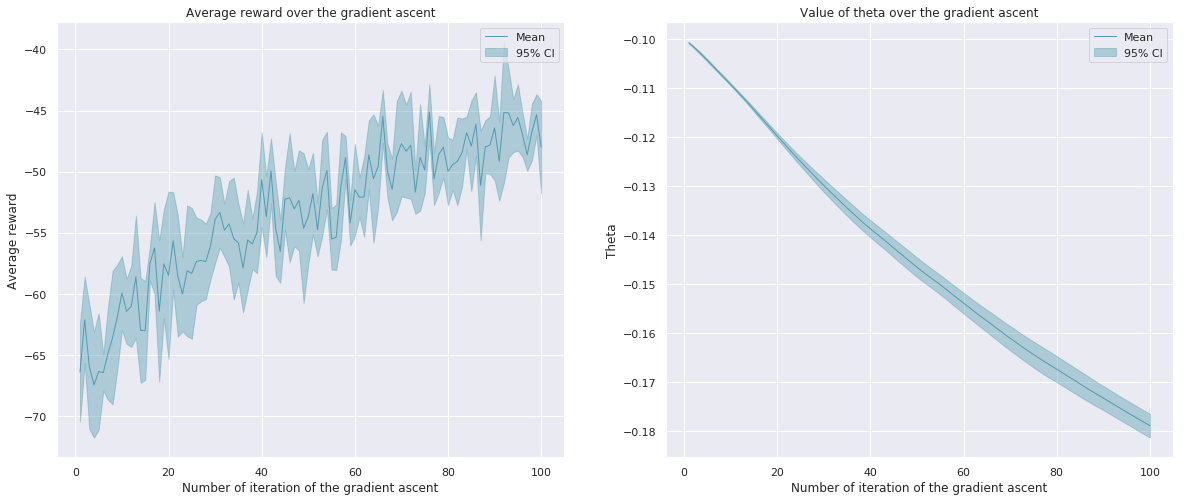

In [70]:
# define the update rule (stepper)
Step = AdamStep()

# REINFOIRCE algoritm
[mean_parameters, avg_return,
 mean_parameters_CI_low, mean_parameters_CI_high,
 avg_return_CI_low, avg_return_CI_high] = REINFORCE(env, gaussianPolicy, Step=Step)

#####################################################
# Figures
#####################################################
figures(mean_parameters, avg_return, mean_parameters_CI_low, mean_parameters_CI_high,
        avg_return_CI_low, avg_return_CI_high)

__Commentaries__:
* With these three past graphics we can understand better the influence of the learning rate $\alpha_t$. When $\alpha_t$ is big as in the figure 1, we are going to do big steps but the convergence is not stable (we can observe a big variance) and so we do not converge in practice. When $\alpha_t$ is low as in Figure 2, we can observe that the convergence is really stable (a very small variance). However as we do very small steps, the convergence is very slow. Finally in the last graphic we implement the Adam Step. Here, we can observe we have a balance between the two past solutions. However, among all our simulations, it appears that $\alpha_t=10^{-5}$ is the best trade-off between speed of convergence and stability.



## 1.8 - Exploration in Policy Gradient

In [12]:
def addOptimism(env, actions, states, rewards, beta=0, n_bins_A=20, n_bins_S=10):
    """This function adds optimism to rewards."""
      
    # Initialisation of N(\phi)
    N_phi_t = np.zeros((n_bins_S + 1, n_bins_A + 1), dtype=int)
    
    for i in range(len(actions)):
        
        # Extract action and state
        a_t = np.clip(actions[i, 0], -env.max_action, env.max_action)
        s_t = np.clip(states[i, 0], -env.max_pos, env.max_pos)
        
        # Extract the revelant bin of (s_t, a_t)
        bin_id_a_t = int((a_t + env.max_action) // (2 * env.max_action) * n_bins_A)
        bin_id_s_t = int((s_t + env.max_pos) // (2 * env.max_pos) * n_bins_S)

        # Update the counter
        N_phi_t[bin_id_s_t, bin_id_a_t] += 1
        
        # Update reward
        rewards[i] += beta * 1 / (np.sqrt(N_phi_t[bin_id_s_t, bin_id_a_t]))
        
    return rewards

100%|██████████| 5/5 [05:21<00:00, 64.22s/it]


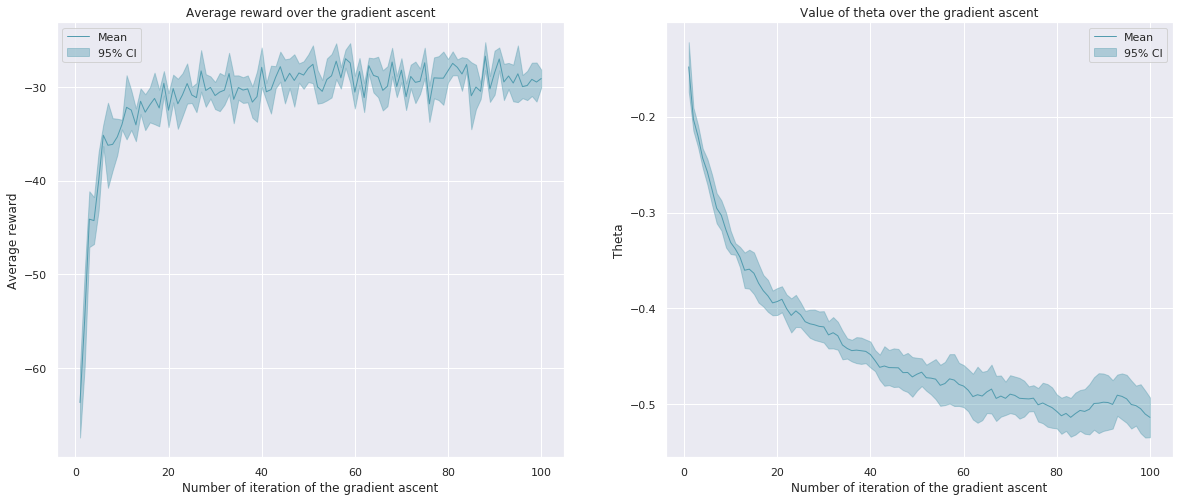

In [13]:
# n_exploration
n_experiences = 5

# Optimism
def optimism(env, actions, states, rewards, beta=20):
    return addOptimism(env, actions, states, rewards)

# REINFOIRCE algoritm
[mean_parameters, avg_return,
 mean_parameters_CI_low, mean_parameters_CI_high,
 avg_return_CI_low, avg_return_CI_high] = REINFORCE(env, gaussianPolicy,
                                                    n_experiences=n_experiences,
                                                    addOptimism=optimism)

#####################################################
# Figures
#####################################################
figures(mean_parameters, avg_return, mean_parameters_CI_low, mean_parameters_CI_high,
        avg_return_CI_low, avg_return_CI_high)

100%|██████████| 5/5 [05:23<00:00, 64.68s/it]


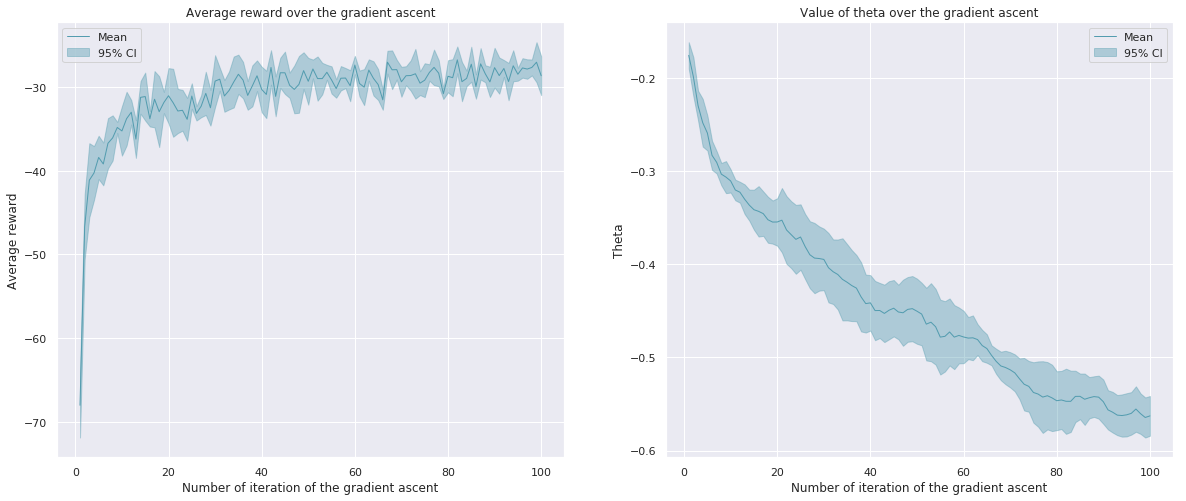

In [12]:
# n_exploration
n_experiences = 5

# Optimism
def optimism(env, actions, states, rewards, beta=0):
    return addOptimism(env, actions, states, rewards)

# REINFOIRCE algoritm
[mean_parameters, avg_return,
 mean_parameters_CI_low, mean_parameters_CI_high,
 avg_return_CI_low, avg_return_CI_high] = REINFORCE(env, gaussianPolicy,
                                                    n_experiences=n_experiences,
                                                    addOptimism=optimism)

#####################################################
# Figures
#####################################################
figures(mean_parameters, avg_return, mean_parameters_CI_low, mean_parameters_CI_high,
        avg_return_CI_low, avg_return_CI_high)

__Commentaries:__
* The first graphic is obtained with $\beta=20$ and the second one with $\beta=0$. Thanks to these two graphic we understand its influence on the exploration. In fact, when $\beta$ is big as in the first graphic, we explore more and so the variance is reduced between the experiences because all of them have more chance to explore the same domain of the space state-action. However, we contast also that the convergences towards the optimal $\theta$ is slower precisely because of this exploration.

# 2 - Off-Policy Reinforcement Learning with Value Function Approximation

## 2.0 - Definition of the environment

In [14]:
#################################################################
# Environment
#################################################################
env = lqg1d.LQG1D(initial_state_type='random')
discount = 0.9
horizon = 50
n_episodes = 50

actions = discrete_actions = np.linspace(-8, 8, 20)
states = discrete_states = np.linspace(-10, 10, 20)

def make_grid(x, y):
    m = np.meshgrid(x, y, copy=False, indexing='ij')
    return np.vstack(m).reshape(2, -1).T

SA = make_grid(states, actions)
S, A = SA[:, 0], SA[:, 1]

## 2.1 - Definition of the behavorial policy

In [17]:
class behavorialPolicy(object):
    """Define a behavorial policy which explores the space of actions and states
       uniformly."""
    
    def __init__(self, actions):
        """Initialisation of the policy."""
        self.actions = actions

    def draw_action(self, s):
        """Return a sampled action according to the uniform policy at state s."""
    
        # Draw a sample of the gaussian policy
        result = np.random.choice(self.actions)

        return result

## 2.2 - Generation of the dataset

In [18]:
def generateDataset(behavorial_policy, horizon=50, n_episodes=50):
    """Generate a datset according to the behavorial policy given in arguments."""
    
    # Computation of the samples
    dataset = utils.collect_episodes(env, n_episodes=n_episodes,
                                     policy=behavorial_policy, horizon=horizon)
    
    # Creation of the dataset
    D_n = np.zeros((horizon * n_episodes, 2))
    
    for i, episode in enumerate(dataset):
        
        # Extract states and actions
        states = episode["states"].reshape(-1)
        actions = episode["actions"].reshape(-1)
        
        # Update D_n
        D_n[i*horizon:(i+1)*horizon, 0] = states
        D_n[i*horizon:(i+1)*horizon, 1] = actions
        
    return D_n

## 2.3 - Definition of FQI

### 2.3.1 - Auxilary functions

In [19]:
def index(value, Array):
    """Return the index of value in Array."""
    
    # Index of value
    i, = np.where(Array == value)
    
    return i

In [20]:
def phi(S=states, A=actions):
    """Definition of the feature fonction."""
    
    # Parameter
    n_S = len(S)
    n_A = len(A)
    
    # Initialisation of the resulting array
    result = np.zeros((n_S, n_A, 3))
    
    # Compute the result of phi for each pair of (state, action)
    for i, s in enumerate(S):
        for j, a in enumerate(A):
        
            # Update result
            result[i, j, :] = np.array([a, s * a, s ** 2 + a ** 2])
    
    return result

In [21]:
def phiCouple(D):
    """Compute the feauture value over the couples in D."""
    
    # Parameter
    n = len(D)
    
    # Initialisation of the resulting array
    result = np.zeros((n, 3))
    
    # Compute the result of phi for each pair of (state, action)
    for i, couple in enumerate(D):
        
        # Extract s_i and a_i
        s = couple[0]
        a = couple[1]
        
        # Update result
        result[i, :] = np.array([a, s * a, s ** 2 + a ** 2])
    
    return result

In [22]:
def Q_max(s, theta_k, A=actions, r_max=1000, discount=0.9):
    """Return the maximum value of Q among A for the given state and theta."""
    
    # Computation of Q
    phi_matrix = phi([s], A).reshape((len(A), 3))
    Q = np.dot(phi_matrix, theta_k).reshape(-1)
    
    # Return the maximum
    value = np.clip(np.max(Q), -r_max / (1 - discount), r_max / (1 - discount))

    return value

### 2.3.2 - Definition of the FQI function

In [23]:
def fqi(env, D_n, Phi_Mat, S=S, discount=0.9, n=50, lmbda=0.01):
    """Executes the fitted Q-iteration algorithm."""
    
    # Computation of number of iterations K
    K = len(D_n) // n
    
    # Initialisation of theta and phi
    theta_k = np.zeros((3, 1))
    
    # Saving array of all the theta
    theta_l = [theta_k]
    
    # Iteration of optimisation
    for k in range(K):
        
        # Extract n samples
        # D_batch = D_n[n * k: n*(k + 1),:]
        idx = np.random.randint(len(D_n), size=n)
        D_batch = D_n[idx, :]
    
        # Build testing set
        y_t = np.zeros((len(D_batch), 1))
        
        for i in range(len(D_batch)):
            
            # Extract a_i, s_i
            s_i = D_batch[i, 0]
            a_i = D_batch[i, 1]
            
            # Sample s_i' and r_i
            r_i = -np.dot(s_i, np.dot(env.Q, s_i)) -\
                  np.dot(a_i, np.dot(env.R, a_i))
            s_i_prime = np.clip(np.dot(env.A, s_i) + np.dot(env.B, a_i),
                                -env.max_pos, env.max_pos)[0, 0]
            
            # Compute y_i
            y_i = r_i + discount * Q_max(s_i_prime, theta_k)
            
            # Append the training set
            y_t[i, :] = y_i
            
        # Resoltuion of the least square problem
        Z_t = phiCouple(D_batch)
        inv = np.linalg.inv(np.dot(Z_t.T, Z_t) + lmbda * np.eye(3))
        theta_k = np.dot(inv, np.dot(Z_t.T, y_t))
        theta_l.append(theta_k)
        
    return theta_l

In [24]:
class greedyPolicy(object):
    """Define the greedy policy according to the given theta."""
    
    def __init__(self, theta, A=actions):
        """Initialisation of the policy."""
        self.actions = A
        self.theta = theta

    def draw_action(self, s):
        """Return a sampled action according to the greedy policy at state s."""
        
        # Draw of the greedy policy
        phi_matrix =  phi([s], self.actions).reshape((len(self.actions), 3))
        Q = np.dot(phi_matrix, theta_k).reshape(-1)
        sample = self.actions[np.argmax(Q)]

        return sample

## 2.4 - Results

Optimal K: [[-0.58840335]] Covariance S: 0.001


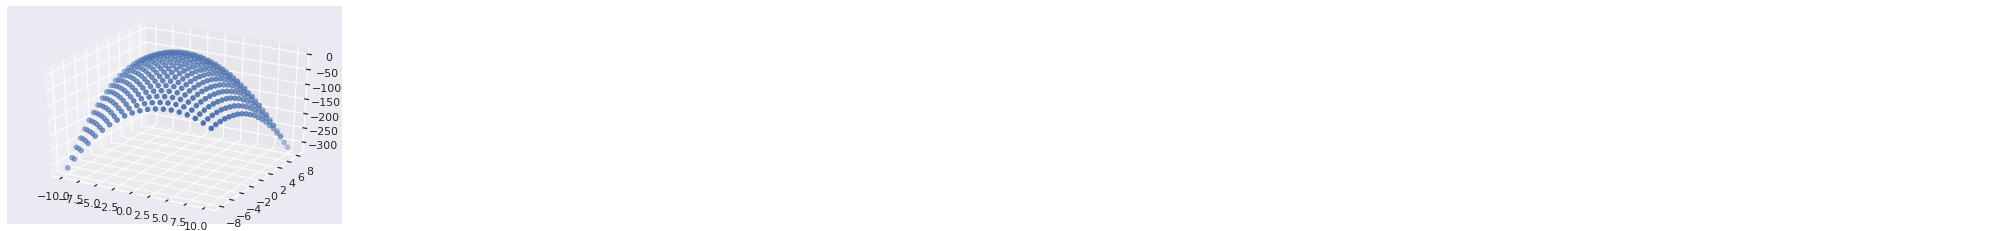

In [219]:
#################################################################
# Show the optimal Q-function
#################################################################

K, cov = env.computeOptimalK(discount), 0.001
print('Optimal K: {} Covariance S: {}'.format(K, cov))

Q_fun_ = np.vectorize(lambda s, a: env.computeQFunction(s, a, K, cov, discount, 1))
Q_fun = lambda X: Q_fun_(X[:, 0], X[:, 1])

Q_opt = Q_fun(SA)

# Figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(S, A, Q_opt)
ax.mouse_init()
plt.show()

In [223]:
#################################################################
# Collect the samples using the behavioural policy
#################################################################
# You should use discrete actions
beh_policy = behavorialPolicy(actions)
D_n = generateDataset(beh_policy, horizon=horizon, n_episodes=n_episodes)

# Generation of the feature matrix
Phi_Matrix = phi(states, actions)

# Number of experiences
n_experiences = 20

# define FQI
performances = [[] for exp in range(n_experiences)]

for exp in tqdm.tqdm(range(n_experiences)):
    
    theta_l = fqi(env, D_n, Phi_Matrix)

    for theta_k in theta_l:

        # Computation of the greedy policy
        policy_k = greedyPolicy(theta_k)

        # plot obtained Q-function against the true one
        J = utils.estimate_performance(env, policy=policy_k, horizon=horizon,
                                       n_episodes=n_episodes, gamma=discount)
        performances[exp].append(J)

100%|██████████| 20/20 [06:18<00:00, 18.43s/it]


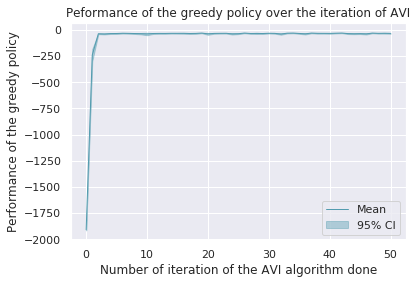

In [224]:
#################################################################
# Display the performance
#################################################################
%matplotlib inline

# Converting resulting list
performances = np.array(performances)

# Initialisation of the figure
fig, axs = plt.subplots()

# X data
x = np.linspace(0, n_episodes, n_episodes+1)
y = np.mean(performances, axis=0)

# Compute the CI bounds
low_CI, upper_CI = computeCIBounds(performances)

# Plot the data, set the linewidth, color and transparency of the
# line, provide a label for the legend
axs.plot(x, y, lw=1, color='#539caf', alpha=1, label='Mean')

# Shade the confidence interval
axs.fill_between(x, low_CI, upper_CI, color ='#539caf', alpha=0.4, label='95% CI')

# Label the axes and provide a title
axs.set_title("Peformance of the greedy policy over the iterations of AVI")
axs.set_xlabel("Number of iterations of the AVI algorithm done")
axs.set_ylabel("Performance of the greedy policy")

# Display legend
axs.legend(loc='best')
plt.show()

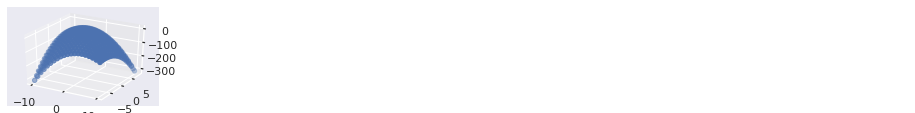

In [233]:
# Figure
fig = plt.figure()
ax = fig.add_subplot(221, projection='3d')
ax.scatter(S, A, Q_opt)
ax.mouse_init()
plt.show()

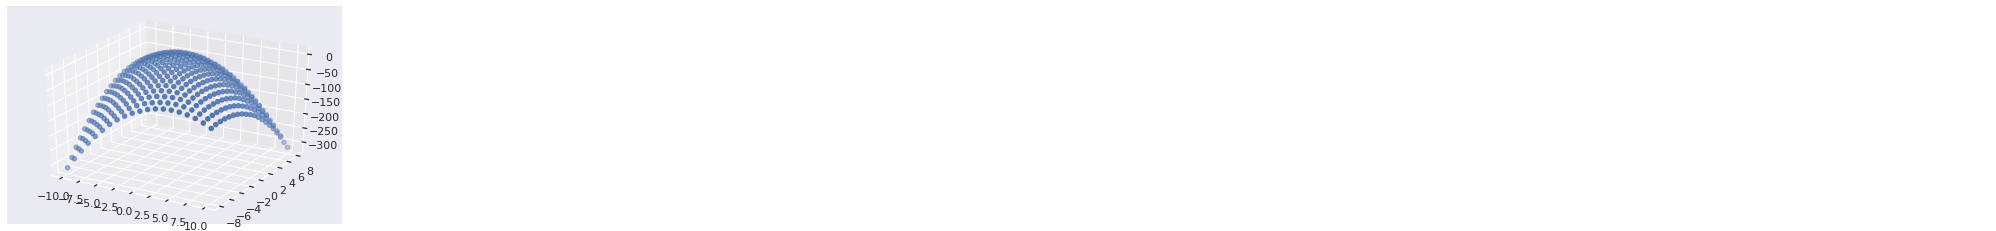

In [232]:
# Q_obtained
theta = theta_l[-1]
Q_fun_2 = np.vectorize(lambda s, a: Q_max(s, theta=theta, A=[a]))
Q_fun_2 = lambda X: Q_fun_2(X[:, 0], X[:, 1])
Q_obtained = Q_fun(SA)

# Figure
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.scatter(S, A, Q_obtained)

ax.mouse_init()
plt.show()